In [1]:
import pandas as pd
import os
import torch
import sklearn as sl
import numpy as np
from torch import nn
import torch.nn.functional as F

## Data Download

In [2]:
from functions import downloadData

path = (r'C:\Users\Luke\Downloads\reviews_Electronics_5.json')

data = downloadData(path = path, n = 100000)

In [3]:
data.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


**Data Transform**

In [4]:
from functions import advTransformData

transformed_data = advTransformData(data)

create columns we
create columns got
create columns this
create columns gps
create columns for
create columns my
create columns husband
create columns over
create columns road
create columns very
create columns impressed
create columns shipping
create columns time
create columns it
create columns arrived
create columns few
create columns days
create columns earlier
create columns than
create columns expected
create columns within
create columns week
create columns of
create columns use
create columns however
create columns started
create columns freezing
create columns up
create columns could
create columns just
create columns been
create columns glitch
create columns that
create columns unit
create columns worked
create columns great
create columns will
create columns work
create columns normal
create columns person
create columns as
create columns well
create columns but
create columns does
create columns have
create columns option
create columns big
create columns truck
create colum

7000

In [5]:
transformed_data.head(5)

,overall,overall_positive,we,got,this,gps,for,my,husband,over,...,figured,micro,booting,cm,capabilities,running,rd,party,stock,form
0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,1
3,0,0,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,1


## Modelling

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [15]:
from functions import NeuralNetwork
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

#We need to first rebalance the transformed dataset.
data_class_1 = transformed_data[transformed_data.overall_positive==1]
data_class_0 = transformed_data[transformed_data.overall_positive==0]

class_1_resampled = resample(data_class_1, replace=False, n_samples=len(data_class_0), random_state=123)
transformed_data = pd.concat([data_class_0, class_1_resampled])

#Create data frames for x and y
response_var_binary = transformed_data['overall_positive']
response_var = transformed_data['overall']
predictor_var = transformed_data.drop(['overall_positive', 'overall'], axis = 1)

#Create test and train datasets
X_train_binary, X_test_binary, Y_train_binary, Y_test_binary = train_test_split(predictor_var, response_var_binary, test_size=0.1, random_state=42, stratify=response_var_binary)

#We need to account for unbalanced classes
Y_train_binary

#Create tensors
response_var_binary_t = torch.tensor(Y_train_binary.values, dtype = torch.float32).to(device)
predictor_var_t = torch.tensor(X_train_binary.values, dtype = torch.float32).to(device)

#Create model
n_columns = len(transformed_data.columns)-2

model = NeuralNetwork(n_input = n_columns, n_hidden_layer = n_columns, n_output = 1, learning_rate = 0.01).to(device)
print(model)

NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=1990, out_features=1990, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1990, out_features=1990, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1990, out_features=1990, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1990, out_features=1990, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1990, out_features=1, bias=True)
    (9): Sigmoid()
  )
  (loss_function): BCELoss()
)


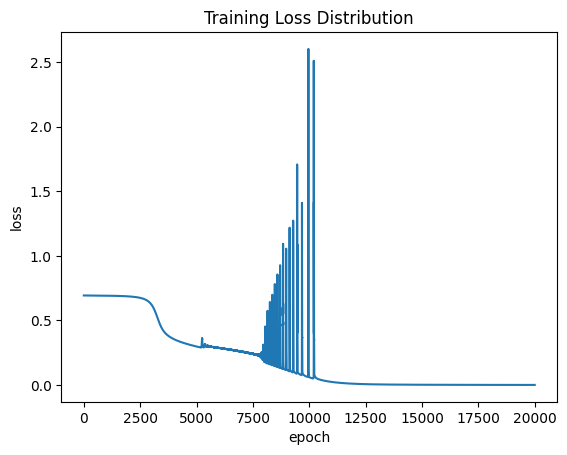

In [16]:
model.train(x_train = predictor_var_t, y_train = response_var_binary_t, batch_size=20000)

## Model Diagnostics ##

In [18]:
from utils import accuracy

X_test_binary_t = torch.tensor(X_test_binary.values, dtype = torch.float32).to(device)

predictions_binary = model.model(X_test_binary_t).detach().cpu().numpy()
#Turn probability into prediction
predictions_binary = np.where(predictions_binary > 0.5, 1, 0)

accuracy(Y_test_binary, predictions_binary)

Accuracy: 0.8578993821712269
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1133
           1       0.86      0.85      0.86      1133

    accuracy                           0.86      2266
   macro avg       0.86      0.86      0.86      2266
weighted avg       0.86      0.86      0.86      2266



In [19]:
from utils import confusionMatrix

confusionMatrix(Y_test_binary, predictions_binary)

Confusion Matrix:

False Positives: 156
False Negatives: 166
True Positives: 967
True Negatives: 977
